In [10]:
import itertools
from functools import lru_cache
from collections import defaultdict
import json
import re
from html import escape
import warnings
import pathlib
import requests

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
import seaborn as sns
from IPython.display import IFrame, HTML
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
import networkx as nx
from pyvis.network import Network
from rdkit import Chem
from rdkit.Chem import DataStructs
import MDAnalysis as mda
from MDAnalysis.topology.tables import vdwradii
import prolif as plf
from prolif.plotting.network import LigNetwork

In [48]:
# download MD simulation files if necessary
data = pathlib.Path("../Data")
url = "https://submission.gpcrmd.org/dynadb/files/Dynamics"
for filename in ["11796_dyn_195.psf", "11792_trj_195.xtc"]:
    path = data / filename
    if not path.is_file():
        target = f"{url}/{filename}"
        !wget {target} -P {str(data)} --quiet --show-progress

# load trajectory with MDAnalysis
u = mda.Universe(
    "../Data/11796_dyn_195.psf",
    "../Data/11792_trj_195.xtc"
)
elements = [mda.topology.guessers.guess_atom_element(n) for n in u.atoms.names]
u.add_TopologyAttr("elements", elements)
# create selections for the ligand and protein
lig = u.atoms.select_atoms("resname CVD")
prot = u.atoms.select_atoms("protein")
print(lig)
# use default interactions
fp = plf.Fingerprint()

<AtomGroup [<Atom 4852: O1 of type OG311 of resname CVD, resid 1 and segid LIG>, <Atom 4853: C1 of type CG311 of resname CVD, resid 1 and segid LIG>, <Atom 4854: C2 of type CG321 of resname CVD, resid 1 and segid LIG>, ..., <Atom 4906: H24X of type HGA3 of resname CVD, resid 1 and segid LIG>, <Atom 4907: H24Y of type HGA3 of resname CVD, resid 1 and segid LIG>, <Atom 4908: H24Z of type HGA3 of resname CVD, resid 1 and segid LIG>]>


In [50]:
# run on a slice of frames from begining to end with a step of 5
# so that there's 1ns between each analyzed frames
fp.run(u.trajectory[::5], lig, prot)
# convert the results to a pandas DataFrame
df = fp.to_dataframe()
df.to_pickle("pickles/ifp_df.pkl")
# show only the 20 first frames
df.head(20).astype(np.uint8)

  0%|          | 0/500 [00:00<?, ?it/s]

ligand             CVD1                                                  \
protein           MET48       GLY98      LEU101      VAL102      TRP117   
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic   
Frame                                                                     
0                     0           1           1           0           1   
5                     0           1           1           1           1   
10                    0           1           1           1           1   
15                    0           0           1           1           1   
20                    0           1           1           0           1   
25                    0           1           1           1           1   
30                    0           1           1           0           1   
35                    0           1           1           1           1   
40                    0           0           1           1           1   
45                    0           1           1           0           1   
50                    0           0           1           1           1   
55                    0           1           1           1           1   
60                    0           1           1           1           1   
65                    0           0           1           1           1   
70                    0           1           1           1           1   
75                    0           1           1           1           1   
80                    0           0           1           1           1   
85                    0           0           1           0           1   
90                    0           1           1           1           1   
95                    0           1           1           1           1   

ligand                                                           ...  \
protein                     THR118      ASP121                   ...   
interaction PiStacking Hydrophobic Hydrophobic HBDonor Cationic  ...   
Frame                                                            ...   
0                    1           0           1       1        1  ...   
5                    1           0           1       1        1  ...   
10                   0           0           1       1        1  ...   
15                   0           0           1       1        1  ...   
20                   0           0           1       1        1  ...   
25                   0           0           1       1        1  ...   
30                   0           0           1       1        1  ...   
35                   0           0           1       1        1  ...   
40                   0           0           1       1        1  ...   
45                   0           0           1       1        1  ...   
50                   0           0           1       1        1  ...   
55                   1           0           1       1        1  ...   
60                   1           0           1       1        1  ...   
65                   0           0           1       1        1  ...   
70                   0           0           1       1        1  ...   
75                   0           0           1       1        1  ...   
80                   0           0           1       1        1  ...   
85                   0           0           1       1        1  ...   
90                   0           0           1       1        1  ...   
95                   0           0           1       1        1  ...   

ligand                                                                        \
protein          ASN329                         TRP330                         
interaction Hydrophobic HBDonor HBAcceptor Hydrophobic HBAcceptor PiStacking   
Frame                                                                          
0                     1       1          1           0          0          0   
5                     1       1          1           0          0     

In [18]:
# with atom indices
df = fp.to_dataframe(return_atoms=True)
df.to_pickle("pickles/ifp_df_atoms.pkl")
df.head(10)

ligand               ERM1                                              \
protein            ALA216        ALA343   ASP129                        
interaction   Hydrophobic   Hydrophobic Cationic  HBDonor Hydrophobic   
Frame                                                                   
0                  (0, 4)  (None, None)  (13, 8)  (52, 8)      (8, 7)   
5                  (0, 4)  (None, None)  (13, 8)  (52, 8)      (8, 7)   
10                 (0, 4)  (None, None)  (13, 8)  (52, 8)      (8, 7)   
15                 (0, 4)  (None, None)  (13, 8)  (52, 9)      (8, 7)   
20                 (0, 4)  (None, None)  (13, 8)  (52, 9)      (8, 7)   
25                 (5, 4)  (None, None)  (13, 8)  (52, 8)      (8, 7)   
30           (None, None)  (None, None)  (13, 8)  (52, 8)      (8, 7)   
35                 (0, 4)  (None, None)  (13, 8)  (52, 9)      (8, 7)   
40           (None, None)  (None, None)  (13, 8)  (52, 9)      (8, 7)   
45                 (0, 4)  (None, None)  (13, 8)  (52, 9)      (8, 7)   

ligand                                                                         \
protein          ASP352      CYS133        CYS199        CYS344        GLU198   
interaction Hydrophobic Hydrophobic   Hydrophobic   Hydrophobic   Hydrophobic   
Frame                                                                           
0               (18, 2)      (0, 4)  (None, None)  (None, None)  (None, None)   
5               (18, 7)      (0, 4)  (None, None)  (None, None)  (None, None)   
10              (18, 7)      (0, 4)       (22, 8)  (None, None)  (None, None)   
15              (18, 2)      (0, 4)  (None, None)  (None, None)  (None, None)   
20              (18, 2)      (0, 4)  (None, None)  (None, None)  (None, None)   
25              (18, 2)      (0, 4)       (22, 8)  (None, None)  (None, None)   
30              (18, 7)      (0, 4)       (22, 8)  (None, None)  (None, None)   
35              (18, 2)      (0, 4)  (None, None)  (None, None)  (None, None)   
40              (18, 2)      (0, 4)       (22, 8)  (None, None)  (None, None)   
45              (18, 2)      (0, 7)  (None, None)  (None, None)  (None, None)   

ligand       ...                                                          \
protein      ...        TRP345                      TRP356        TYR109   
interaction  ...    HBAcceptor   Hydrophobic   Hydrophobic   Hydrophobic   
Frame        ...                                                           
0            ...  (None, None)  (None, None)  (None, None)      (18, 17)   
5            ...  (None, None)  (None, None)  (None, None)      (18, 17)   
10           ...  (None, None)  (None, None)  (None, None)      (22, 17)   
15           ...  (None, None)  (None, None)  (None, None)      (22, 17)   
20           ...  (None, None)  (None, None)  (None, None)      (22, 17)   
25           ...  (None, None)  (None, None)  (None, None)  (None, None)   
30           ...  (None, None)  (None, None)  (None, None)  (None, None)   
35           ...  (None, None)  (None, None)  (None, None)  (None, None)   
40           ...  (None, None)  (None, None)  (None, None)      (22, 17)   
45           ...  (None, None)  (None, None)  (None, None)      (22, 12)   

ligand                                                                      \
protein          TYR359         TYR38         TYR40      VAL200     VAL201   
interaction Hydrophobic   Hydrophobic   Hydrophobic Hydrophobic HBAcceptor   
Frame                                                                        
0               (8, 10)  (None, None)  (None, None)     (12, 4)    (28, 1)   
5               (8, 10)  (None, None)  (None, None)     (11, 2)    (28, 1)   
10               (8, 8)  (None, None)  (None, None)     (11, 2)    (28, 1)   
15              (8, 10)  (None, None)  (None, None)     (11, 2)    (28, 1)   
20              (8, 10)  (None, None)  (None, None)     (11, 2)    (28, 1)   
25              (8, 10)  (None, None)  (None, None)     (11, 2)    (28, 1) 

In [25]:
df = (pd.read_pickle("pickles/ifp_df.pkl")
        .astype(np.uint8))
(df.drop("Hydrophobic", level="interaction", axis=1)
   .head(20))

ligand         ERM1                                                       \
protein      ASP129           THR134     VAL201  SER212  THR213   PHE330   
interaction HBDonor Cationic HBDonor HBAcceptor HBDonor HBDonor CationPi   
Frame                                                                      
0                 1        1       0          1       1       0        0   
5                 1        1       0          1       0       0        0   
10                1        1       0          1       0       0        0   
15                1        1       0          1       0       0        0   
20                1        1       0          1       0       0        0   
25                1        1       0          1       0       0        0   
30                1        1       0          1       0       0        0   
35                1        1       0          1       1       0        0   
40                1        1       0          1       1       0        0   
45                1        1       0          1       1       0        0   
50                1        1       0          1       0       0        0   
55                1        1       0          1       0       0        0   
60                1        1       0          1       0       0        0   
65                1        1       0          1       0       0        0   
70                1        1       0          1       0       0        0   
75                1        1       0          1       0       0        0   
80                1        1       0          1       1       0        0   
85                1        1       0          1       0       0        0   
90                1        1       0          1       0       0        0   
95                1        1       0          1       0       0        0   

ligand                                                                         
protein                    PHE331     TRP345     PHE346     PHE351     THR355  
interaction PiStacking PiStacking HBAcceptor PiStacking PiStacking HBAcceptor  
Frame                                                                          
0                    0          1          0          0          0          0  
5                    0          1          0          0          0          0  
10                   1          1          0          0          0          0  
15                   0          0          0          0          0          0  
20                   1          1          0          0          0          0  
25                   0          1          0          0          0          0  
30                   0          1          0          0          0          0  
35                   1          0          0          0          0          0  
40                   0          0          0          0          0          0  
45                   1          0          0          0          0          0  
50                   0          0          0          0          0          0  
55                   0          0          0          0          0          0  
60                   1          0          0          0          0          0  
65                   0          0          0          0          1          0  
70                   1          1          0          0          1          0  
75                   0          0          0          0          0          0  
80                   1          0          0          0          0          0  
85                   0          1          0          0          0          0  
90                   1          0          0          0          1          0  
95                   1          1          0          0          0          0

In [26]:
# share, by residue, of pi-stacking interactions
g = (df.xs("PiStacking", level="interaction", axis=1)
       .sum())
(100 * g / g.sum()).sort_values(ascending=False)

ligand  protein
ERM1    PHE331     48.368794
        PHE330     28.652482
        PHE351     22.269504
        PHE346      0.709220
dtype: float64

In [27]:
# share, by interaction type, of SER212 interactions
g = (df.xs("SER212", level="protein", axis=1)
       .sum())
(100 * g / g.sum()).sort_values(ascending=False)

ligand  interaction
ERM1    Hydrophobic    68.567455
        HBDonor        31.432545
dtype: float64

In [29]:
# occurence percentage of each interaction along the simulation
(df.groupby(level="interaction", axis=1)
   .sum()
   .astype(bool)
   .mean()
   .sort_values(ascending=False))

interaction
Cationic       1.000
HBDonor        1.000
Hydrophobic    1.000
HBAcceptor     0.918
PiStacking     0.850
CationPi       0.016
dtype: float64

In [30]:
# share of each interaction averaged on all frames
g = (df.groupby(level="interaction", axis=1)
       .sum()
       .mean())
(100 * g / g.sum()).sort_values(ascending=False)

interaction
Hydrophobic    80.808402
HBDonor         5.792489
PiStacking      5.609484
Cationic        3.978358
HBAcceptor      3.747613
CationPi        0.063654
dtype: float64

On average, in each frame 80% of interactions are hydrophobic, 6% are H-bond donor, 6% pi-stacking...etc.

In [31]:
# 10 residues most frequently interacting with the ligand
(df.groupby(level=["ligand", "protein"], axis=1)
   .sum()
   .astype(bool)
   .mean()
   .sort_values(ascending=False)
   .head(10))

ligand  protein
ERM1    PHE330     1.000
        ASP129     1.000
        ILE130     1.000
        VAL201     0.998
        PHE331     0.998
        SER212     0.988
        VAL200     0.982
        TRP327     0.982
        CYS133     0.976
        PHE351     0.974
dtype: float64

In [32]:
# compute tanimoto similarity matrix
bvs = plf.to_bitvectors(df)
mat = []
for bv in bvs:
    mat.append(DataStructs.BulkTanimotoSimilarity(bv, bvs))
mat = pd.DataFrame(mat, index=df.index, columns=df.index)

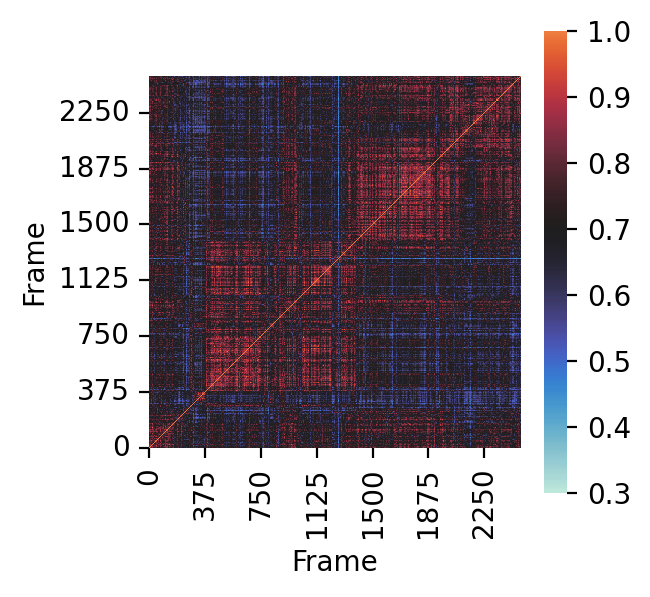

In [33]:
# display heatmap
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.heatmap(
    mat, ax=ax, square=True,
    cmap="icefire",
    vmin=.3, vmax=1, center=.7,
    xticklabels=75, yticklabels=75,
)

ax.invert_yaxis()
fig.patch.set_facecolor('white')

In [34]:
fig.savefig("similarity_matrix.png", bbox_inches="tight", dpi=300)

In [35]:
# KMeans clustering

def bv_to_np(bv):
    """convert rdkit bitvector to numpy array"""
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

fps = np.array([bv_to_np(bv) for bv in bvs])
kmean = KMeans(n_clusters=2, random_state=0)
clusters = kmean.fit_predict(fps)

# get closest frame to each cluster center
closest, dists = vq(kmean.cluster_centers_, fps)
data = df.iloc[closest].copy()
# only show columns with differences between clusters
data.loc[:, data.nunique() > 1]

ligand             ERM1                                              \
protein          TRP125      THR203      THR209  SER212      SER334   
interaction Hydrophobic Hydrophobic Hydrophobic HBDonor Hydrophobic   
Frame                                                                 
420                   1           0           0       1           0   
1680                  0           1           1       0           1   

ligand                              
protein         PHE351      ASP352  
interaction PiStacking Hydrophobic  
Frame                               
420                  1           0  
1680                 0           1

We'll aggregate the IFP and only display interactions that occur in at least 30% of frames

In [36]:
df = pd.read_pickle("pickles/ifp_df_atoms.pkl")
lmol = plf.Molecule.from_mda(lig)
net = LigNetwork.from_ifp(df, lmol, kind="aggregate", threshold=.3, rotation=110)
net

/home/abhik.seal/anaconda3/envs/biobb_Protein-Complex_MDsetup_tutorial/lib/python3.10/site-packages/prolif/plotting/network.py:278: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = (pd.get_dummies(ifp.applymap(lambda x: x[0])


In [37]:
net.show("lignetwork.html")
